In [1]:
!pip install fasttext
!pip install transformers
import fasttext # Static word embeddings
import fasttext.util
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import torch # Neural Networks
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, AdamW # Transformers
from sklearn.manifold import TSNE # Data projection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm # Progress bar
import seaborn as sns
import os
import random
from IPython import display

sns.set_style("darkgrid")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
%matplotlib inline

You should consider upgrading via the '/opt/conda/envs/transf_aug21/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/envs/transf_aug21/bin/python3.9 -m pip install --upgrade pip' command.


# Visualizing the static word vector space

In [2]:
# We'll use the FastText static word embeddings.
# https://fasttext.cc/
# Let's get romanian embeddings for FastText:

fasttext.util.download_model('ro', if_exists='ignore')
ft = fasttext.load_model('cc.ro.300.bin')

In [3]:
# .. and look at how a dense word vector looks like!
salut_vector = ft.get_word_vector('salut')

In [4]:
salut_vector.shape

(300,)

In [5]:
salut_vector

array([ 8.90067667e-02, -5.56648225e-02,  4.40299138e-02,  2.05428079e-02,
        8.97987336e-02,  6.21088669e-02, -6.76264316e-02, -6.29252046e-02,
        4.02962603e-03,  1.16370656e-02, -4.54413705e-03,  3.92945409e-02,
       -9.16965306e-03, -9.28745344e-02, -7.41119608e-02,  6.65741861e-02,
       -8.36958438e-02,  1.27498694e-02, -7.11827353e-03,  2.67495718e-02,
       -1.01469889e-01, -4.51442041e-03, -3.10080349e-02, -9.44064111e-02,
       -2.73393504e-02, -5.12069128e-02, -4.18016613e-02,  4.50888574e-02,
        4.46748361e-02, -1.01687275e-02,  8.27449746e-03,  7.06061050e-02,
       -2.09177453e-02,  6.95424527e-02,  6.84023928e-03,  9.02754888e-02,
       -2.24993397e-02,  8.40425938e-02, -6.65949956e-02, -1.98022779e-02,
        3.25391442e-02,  5.33367358e-02,  5.07385051e-03, -1.00014463e-01,
       -2.11945996e-02, -2.41340287e-02,  3.57306376e-02, -6.87642395e-02,
       -5.00222109e-03,  4.49912287e-02,  5.07919677e-03,  7.93117434e-02,
       -1.90863607e-03, -

In [6]:
# Let's also look at its nearest neighbours
ft.get_nearest_neighbors('salut')

[(0.7033483386039734, 'salut.'),
 (0.689331591129303, '-salut'),
 (0.626398503780365, 'salutul'),
 (0.6229920983314514, 'salutã'),
 (0.6195693016052246, 'salutăm'),
 (0.5931749939918518, 'salut.am'),
 (0.5926427841186523, 'saluturi'),
 (0.5925089120864868, 'Salut'),
 (0.5883165001869202, 'salută'),
 (0.5769476294517517, 'salutare')]

In [7]:
# Print the nearest neighbors of some words

word_list = ['mâncare', 'mânz', 'viezure', 'harbuz', 'păpușoi', 'glod', 'măgar']
vectors = []
labels = []
color_idx = []

r = lambda: random.randint(0,255)

for idx, word in enumerate(word_list):
    vectors.append(ft.get_word_vector(word))
    labels.append(word)
    random_color = '#%02X%02X%02X' % (r(),r(),r())
    color_idx.append(random_color)
    
    print(f'Vecini pentru cuvântul "{word}": ')
    neighbors = ft.get_nearest_neighbors(word)
    for (score, neighbor) in neighbors:
        print(neighbor)
        vectors.append(ft.get_word_vector(neighbor))
        labels.append(neighbor)
        color_idx.append(random_color)

    print('-'*20)

Vecini pentru cuvântul "mâncare": 
mâncarea
mancare
mâncare-
măncare
demâncare
Mâncare
mâncare.
hrană
mâncare.Doar
mîncare
--------------------
Vecini pentru cuvântul "mânz": 
mânzul
măgăruş
ieduț
ied
mînz
iapă
mânzat
căluţ
dulău
iedul
--------------------
Vecini pentru cuvântul "viezure": 
viezure.
Viezure
viezurele
viezuri
viezurelui
Viezurele
viezurii
ciuf
cioacă
şopîrlă
--------------------
Vecini pentru cuvântul "harbuz": 
harbuji
harbujii
lubeniță
harbuzul
harbuzărie
zarzăre
cîrnaţ
lubeniţă
bostan
Icși
--------------------
Vecini pentru cuvântul "păpușoi": 
păpușoiul
păpușoiului
popușoi
păpușoaiele
păpuşoi
Păpușoi
păpuș
cucuruz
păpușică
moșu
--------------------
Vecini pentru cuvântul "glod": 
colb
glodul
mîl
noroi
omăt
balegă
băltoace
nouraș
noroaie
Stă-n
--------------------
Vecini pentru cuvântul "măgar": 
măgar.
măgaruș
măgarul
măgaru
ciomăgar
măgarului
măgaru-n
măgăruş
măgare
Măgar
--------------------


/opt/conda/envs/transf_aug21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/transf_aug21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


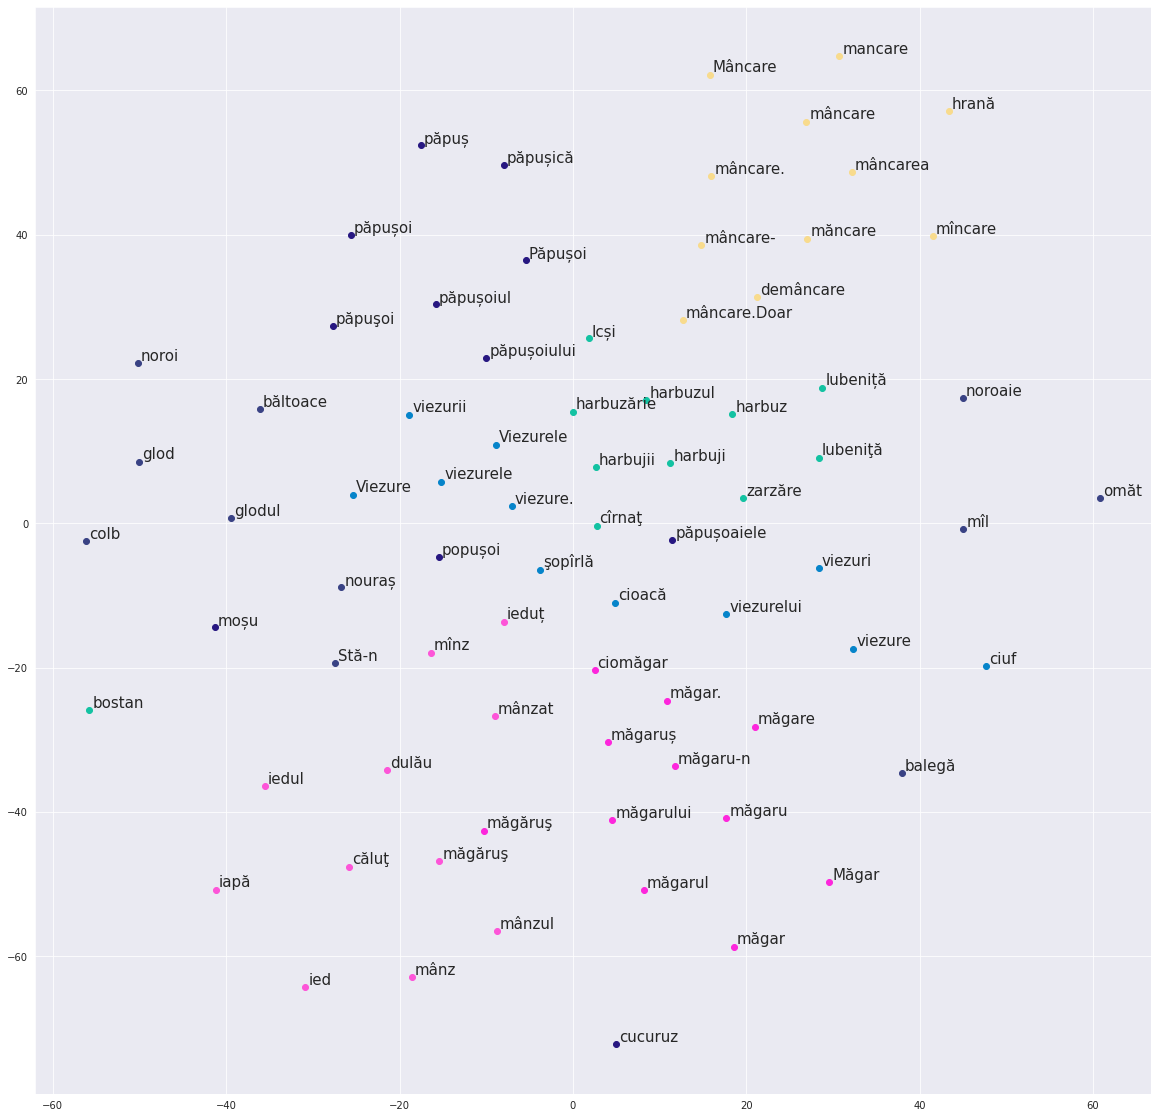

In [8]:
# and then plot them!

def plot_tsne(vectors, labels, colors):
    tsne = TSNE(n_components=2)
    two_dim_proj = tsne.fit_transform(vectors)
    plt.figure(figsize=(20,20))
    
    for vector, label, color in zip(two_dim_proj, labels, colors):
        plt.scatter(vector[0], vector[1], c=color)
        plt.annotate(label, xy=(vector[0], vector[1]), xytext=(3,3), textcoords='offset points', fontsize=15)
    plt.show()
    
plot_tsne(vectors, labels, color_idx)

# Train a Neural Network using FastText embeddings

In [9]:
# First, let's get our dataset.
# We'll use LaRoSeDa, a romanian sentiment analysis dataset.
# Paper link: https://aclanthology.org/2021.eacl-main.81.pdf

!git clone https://github.com/ancatache/LaRoSeDa.git

fatal: destination path 'LaRoSeDa' already exists and is not an empty directory.


In [10]:
# We can find the training and testing data at ./LaRoSeDa/data_splitted
def train_test_valid(train_path='./LaRoSeDa/data_splitted/laroseda_train.json', test_path='./LaRoSeDa/data_splitted/laroseda_test.json', remove_punctuation=True, seed=42):
    """ Returns the train/validation/test splits
        Optionally removes punctuation for the FastText embeddings.
    """
    
    # We first load the train and test data
    laroseda_train = json.load(open(train_path))
    laroseda_test = json.load(open(test_path))

    X_train = []
    y_train = []
    X_test = []
    y_test = []

    # Then we move them to some vectors in memory
    for sample in laroseda_train['reviews']:
        text = sample['content']
        
        if remove_punctuation:
            text = re.sub(r'[^\w\s]', '', text)
        
        X_train.append(text)
        y_train.append(int(sample['starRating']))
        
    for sample in laroseda_test['reviews']:
        text = sample['content']
        
        if remove_punctuation:
            text = re.sub(r'[^\w\s]', '', text)
        
        X_test.append(text)
        y_test.append(int(sample['starRating']))
        
        
    # And we finally split the training data into train/valid
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Get the dataset
X_train, X_val, X_test, y_train, y_val, y_test = train_test_valid()

## Let's look at the label distribution

<AxesSubplot:ylabel='Count'>

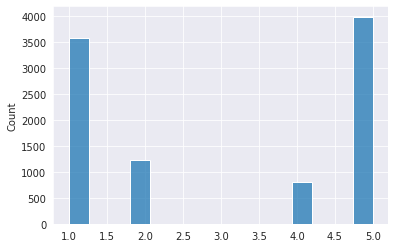

In [11]:
# Train
sns.histplot(y_train)

<AxesSubplot:ylabel='Count'>

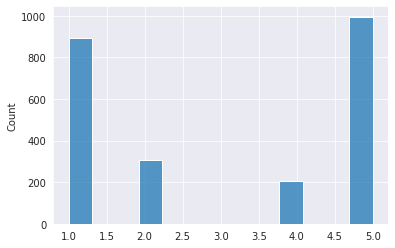

In [12]:
# Validation
sns.histplot(y_val)

<AxesSubplot:ylabel='Count'>

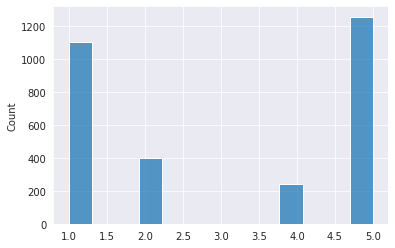

In [13]:
# Test
sns.histplot(y_test)

## The dataset is pretty imbalanced. We'll treat the reviews with scores 1 and 2 as being "negative", and the ones with scores 4 and 5 as being "positive"

In [14]:
def tokenize_and_get_sentence_vector(text, ft):
    """ Tokenizes text and returns sentence vector.
    """
    
    # We tokenize our texts by splitting them where there are spaces
    tokens = text.split(' ')
    # Get dense vectors from our tokens
    dense_vectors = [ft.get_word_vector(tok) for tok in tokens]
    # And compute the mean of the vectors to obtain a sentence vector
    text_vector = np.mean(dense_vectors, axis=0)
    
    return text_vector
        
class DatasetFastText(Dataset):
    def __init__(self, X, y, fasttext):
        self.ft = fasttext
        self.X = X
        # Convert 1/2-star revies to "negative" and 4/5-star reviews to "positive"
        self.y = [0 if y_i in [1,2] else 1 for y_i in y]
            
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        
        text_vector = tokenize_and_get_sentence_vector(text, self.ft)
        
        return torch.tensor(text_vector), torch.tensor(label)

In [15]:
BATCH_SIZE = 128

# Define our datasets and dataloaders

ds_train = DatasetFastText(X_train, y_train, ft)
ds_val = DatasetFastText(X_val, y_val, ft)
ds_test = DatasetFastText(X_test, y_test, ft)

train_dataloader = DataLoader(
    ds_train, sampler=RandomSampler(ds_train), batch_size=BATCH_SIZE, num_workers=4
)

val_dataloader = DataLoader(
    ds_val, sampler=SequentialSampler(ds_val), batch_size=BATCH_SIZE, num_workers=4
)

test_dataloader = DataLoader(
    ds_test, sampler=SequentialSampler(ds_test), batch_size=BATCH_SIZE, num_workers=4
)

In [16]:
# Define our neural network
class LinearModel(nn.Module):
    def __init__(self, in_dim=300, no_classes=2):
        super(LinearModel, self).__init__()
        
        # We'll have a 2-layer fully-connected neural network with a ReLU activation
        self.fc1 = nn.Linear(in_dim, in_dim//2)
        self.fc2 = nn.Linear(in_dim//2, no_classes)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = x
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [17]:
def train_epoch(model, optim, loss_fn, dataloader, epoch_idx):
    """ Trains the model for one epoch and returns the loss together with a classification report
    """
    
    epoch_loss = 0
    # Put the model in training mode
    model.train()
    preds = []
    gt = []
    
    for idx, batch in enumerate(dataloader):
        # Reset gradients
        optim.zero_grad()
        
        inputs, labels = batch
        # Move data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model(inputs.to(device))
        # Calculate the loss and backpropagate
        loss = loss_fn(output, labels)
        loss.backward()
        # Update weights
        optim.step()
        
        epoch_loss += loss.item()
        
        probs = F.softmax(output, dim=-1)
        batch_preds = torch.argmax(probs, dim=1)

        preds.append(batch_preds.cpu().numpy())
        gt.append(labels.cpu().numpy())
    
    # Average the epoch losses
    epoch_loss /= len(dataloader)
    
    preds = np.concatenate(preds)
    gt = np.concatenate(gt)
    
    # Get an epoch classification report
    clf_report = classification_report(gt, preds, output_dict=True)
    
    return epoch_loss, clf_report

def test(model, loss_fn, dataloader):
    """ Computes and returns the loss and classification report for a testing dataset.
    """
    
    test_loss = 0
    # put model in evaluation mode
    model.eval()
    preds = []
    gt = []
    
    # Tell PyTorch that we won't be computing gradients
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            inputs, labels = batch

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            output = model(inputs)
            test_loss += loss_fn(output, labels).item()
            
            probs = F.softmax(output, dim=-1)
            batch_preds = torch.argmax(probs, dim=1)
            
            preds.append(batch_preds.cpu().numpy())
            gt.append(labels.cpu().numpy())
            
    test_loss /= len(dataloader)
    preds = np.concatenate(preds)
    gt = np.concatenate(gt)
    
    # Get a classification report
    clf_report = classification_report(gt, preds, output_dict=True)
    clf_report_text = classification_report(gt, preds)
    
    return test_loss, clf_report, clf_report_text

In [18]:
# Check if there's any available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model, loss and optimizer
model = LinearModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

no_epochs = 20
best_val_loss = 999

In [19]:
# Instantiate our progress bar
pbar = tqdm(range(no_epochs))

# Track our training & validation metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for e in pbar:
    train_loss, clf_report_train = train_epoch(model, optim, loss_fn, train_dataloader, e)
    val_loss, clf_report_val, _ = test(model, loss_fn, val_dataloader)
    
    train_acc = clf_report_train['accuracy']*100
    val_acc = clf_report_val['accuracy']*100
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Set progress bar description
    pbar.set_description(
        "Epoch: %s, t_loss: %.3f, v_loss: %.3f, t_acc: %.2f, v_acc: %.2f" % (e+1, train_loss, val_loss, train_acc, val_acc))
    
    # Save the model with the best loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './best_w2v_model.pt')

Epoch: 20, t_loss: 0.280, v_loss: 0.318, t_acc: 87.96, v_acc: 86.46: 100%|██████████| 20/20 [01:20<00:00,  4.05s/it]


In [20]:
def plot_curve(val1, val2, val1_name='train', val2_name='valid', curve_name='loss'):
    """ Plots two curves.
    """
    epochs = range(1, len(val1)+1)
    
    plt.plot(epochs, val1, label=f'{val1_name} {curve_name}')
    plt.plot(epochs, val2, label=f'{val2_name} {curve_name}')
    
    plt.title(curve_name)
    plt.legend()
    
    plt.show()

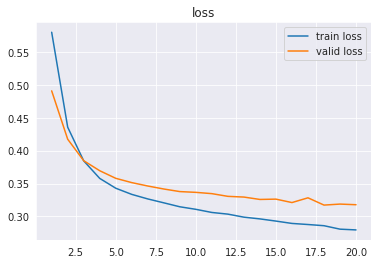

In [21]:
plot_curve(train_losses, val_losses)

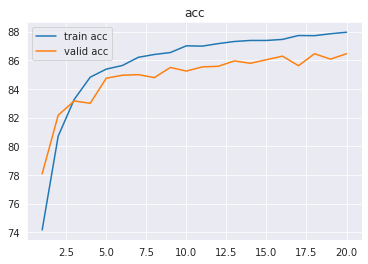

In [22]:
plot_curve(train_accs, val_accs, curve_name='acc')

In [23]:
model.load_state_dict(torch.load('./best_w2v_model.pt'))

<All keys matched successfully>

In [24]:
_, _, clf_report_test = test(model, loss_fn, test_dataloader)
print(clf_report_test)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1500
           1       0.86      0.84      0.85      1500

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



In [25]:
text1 = "produsul nu e bun e chiar destul de rau"
text2 = "produsul nu e rau e chiar destul de bun"

text1_vector = torch.tensor(tokenize_and_get_sentence_vector(text1, ft)).unsqueeze(0).to(device)
text2_vector = torch.tensor(tokenize_and_get_sentence_vector(text2, ft)).unsqueeze(0).to(device)

In [26]:
probabilities = F.softmax(model(text1_vector), dim=-1)[0]
print('Text1: ', text1)
print('Probabilitati: ', probabilities)
print(f'Negativ: {probabilities[0].item()*100:.2f}%')
print(f'Pozitiv: {probabilities[1].item()*100:.2f}%')

Text1:  produsul nu e bun e chiar destul de rau
Probabilitati:  tensor([0.6229, 0.3771], device='cuda:0', grad_fn=<SelectBackward>)
Negativ: 62.29%
Pozitiv: 37.71%


In [27]:
probabilities = F.softmax(model(text2_vector), dim=-1)[0]
print('Text1: ', text1)
print('Probabilitati: ', probabilities)
print(f'Negativ: {probabilities[0].item()*100:.2f}%')
print(f'Pozitiv: {probabilities[1].item()*100:.2f}%')

Text1:  produsul nu e bun e chiar destul de rau
Probabilitati:  tensor([0.6229, 0.3771], device='cuda:0', grad_fn=<SelectBackward>)
Negativ: 62.29%
Pozitiv: 37.71%


## We can see that our model outputs the same probabilities for the two reviews. This is a shortcoming of static word embeddings.

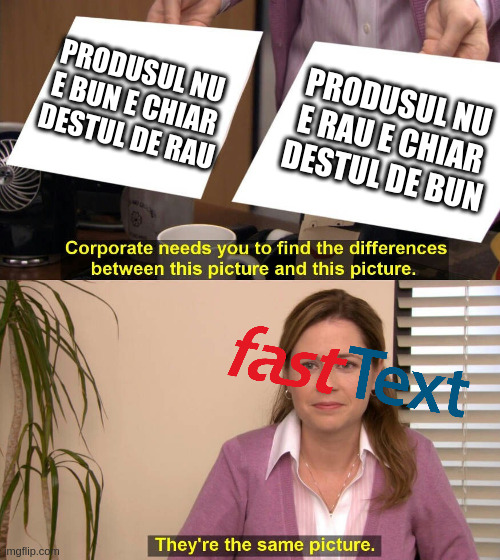

In [28]:
display.Image("https://i.imgur.com/7uCWshM.jpg")

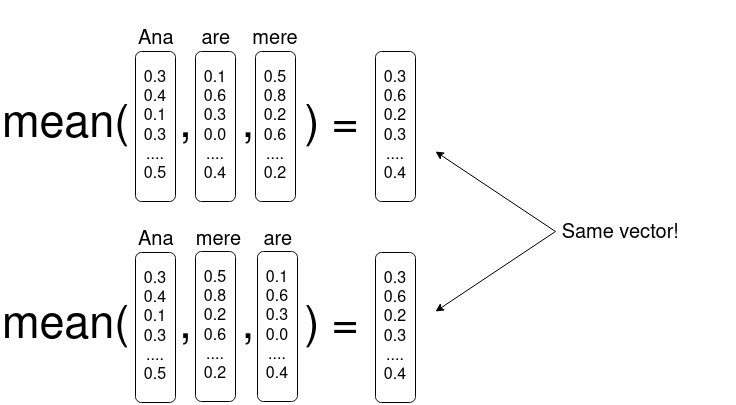

In [29]:
display.Image("https://i.imgur.com/MheS8Ca.png")

# Let's try a contextual embedding model - we'll train a Neural Network using Romanian BERT

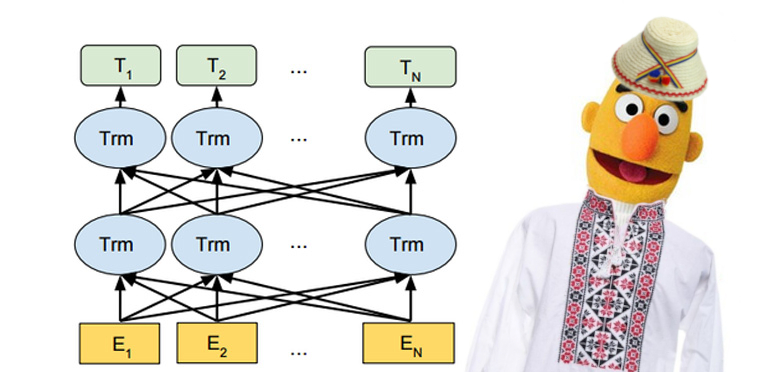

In [30]:
display.Image("https://i.imgur.com/UXNTSV0.jpg")

In [31]:
# First, define the dataset
class DatasetTransformer(Dataset):
    def __init__(self, X, y, tokenizer):
        self.tokenizer = tokenizer
        self.X = X
        self.y = [0 if y_i in [1,2] else 1 for y_i in y]
            
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        
        # Remove cedilla diacritics as suggested in
        # https://huggingface.co/dumitrescustefan/bert-base-romanian-uncased-v1
        text = text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș")
        
        # Tokenize text and return the tensor
        # Maximum length set at 64 tokens for efficiency reasons. The maximum sequence length for BERT is 512.
        text_tensor = self.tokenizer.encode(text, add_special_tokens=True, max_length=64, padding='max_length', return_tensors='pt', truncation=True)
        
        return text_tensor, torch.tensor(label)

In [32]:
class TransformerModel(nn.Module):
    def __init__(self, in_dim=768, no_classes=2):
        super(TransformerModel, self).__init__()
        # Get the romanian Transformer from the huggingface server
        self.transformer = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1")
        # Add a linear layer for classification
        self.fc1 = nn.Linear(in_dim, no_classes)
        
    def forward(self, x):
        out = x.squeeze(1)
        # Get output from Transformer.
        # We want the special [CLS] representation ([:,0,:]) from the last layer ([0]) 
        out = self.transformer(out)[0][:,0,:]
        # We usually add dropout before the final classification layer when using a Transformer
        out = F.dropout(out, p=0.1)
        out = self.fc1(out)
        return out

In [33]:
# Load tokenizer and model
# The tokenizer is the WordPiece tokenizer: https://towardsdatascience.com/wordpiece-subword-based-tokenization-algorithm-1fbd14394ed7
tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1", do_lower_case=True)

In [34]:
# tokenize a sentence and run through the model
tokens = tokenizer.tokenize(text1, add_special_tokens=True)

print(tokens)

['[CLS]', 'produsul', 'nu', 'e', 'bun', 'e', 'chiar', 'destul', 'de', 'rau', '[SEP]']


## Notice the special "[CLS]" and "[SEP]" tokens added.

In [35]:
tokens = tokenizer.tokenize("Vom merge usurel spre supermarketul din centru", add_special_tokens=True)

print(tokens)

['[CLS]', 'vom', 'merge', 'usu', '##rel', 'spre', 'supermarket', '##ul', 'din', 'centru', '[SEP]']


## Notice the wordpieces: 'usu' '##rel' and 'supermarket' '##ul'

In [36]:
# Get the dataset splits once again, this time containing punctuation
X_train, X_val, X_test, y_train, y_val, y_test = train_test_valid(remove_punctuation=False)

ds_train = DatasetTransformer(X_train, y_train, tokenizer)
ds_val = DatasetTransformer(X_val, y_val, tokenizer)
ds_test = DatasetTransformer(X_test, y_test, tokenizer)

BATCH_SIZE = 128

train_dataloader = DataLoader(
    ds_train, sampler=RandomSampler(ds_train), batch_size=BATCH_SIZE, num_workers=4
)

val_dataloader = DataLoader(
    ds_val, sampler=SequentialSampler(ds_val), batch_size=BATCH_SIZE, num_workers=4
)

test_dataloader = DataLoader(
    ds_test, sampler=SequentialSampler(ds_test), batch_size=BATCH_SIZE, num_workers=4
)

In [37]:
# Instantiate our model and move it to GPU
model = TransformerModel().to(device)

# Freeze all the Transformer parameters
for p in model.transformer.parameters():
    p.requires_grad = False
# ... except for the bias terms
trainable_params_transformer = [p for (n, p) in model.transformer.named_parameters() if "bias" in n]
for p in trainable_params_transformer:
    p.requires_grad = True

# We'll train the final layer and the bias terms
trainable_params = list(model.fc1.parameters())
trainable_params.extend(list(trainable_params_transformer))

# Define our loss and optimizer
loss_fn = nn.CrossEntropyLoss()
# We'll use AdamW for the Transformer
optim = torch.optim.AdamW(trainable_params)

no_epochs = 20
best_val_loss = 999

Some weights of the model checkpoint at dumitrescustefan/bert-base-romanian-uncased-v1 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
pbar = tqdm(range(no_epochs))

train_losses = []
val_losses = []

train_accs = []
val_accs = []

for e in pbar:
    train_loss, clf_report_train = train_epoch(model, optim, loss_fn, train_dataloader, e)
    val_loss, clf_report_val, _ = test(model, loss_fn, val_dataloader)
    
    train_acc = clf_report_train['accuracy']*100
    val_acc = clf_report_val['accuracy']*100
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    pbar.set_description(
        "Epoch: %s, t_loss: %.3f, v_loss: %.3f, t_acc: %.2f, v_acc: %.2f" % (e+1, train_loss, val_loss, train_acc, val_acc))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './best_transformer_model.pt')

Epoch: 20, t_loss: 0.092, v_loss: 0.165, t_acc: 96.45, v_acc: 94.25: 100%|██████████| 20/20 [09:17<00:00, 27.89s/it]


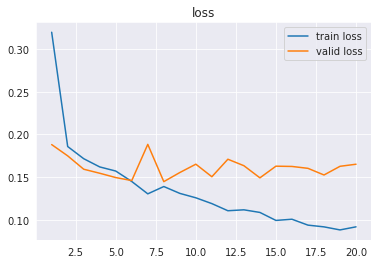

In [39]:
plot_curve(train_losses, val_losses)

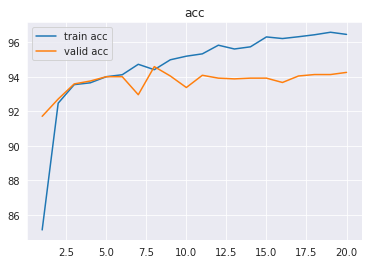

In [40]:
plot_curve(train_accs, val_accs, curve_name='acc')

In [41]:
model.load_state_dict(torch.load('./best_transformer_model.pt'))

<All keys matched successfully>

In [42]:
_, _, clf_report_test = test(model, loss_fn, test_dataloader)
print(clf_report_test)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1500
           1       0.94      0.93      0.94      1500

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [43]:
text1_tokens = tokenizer.encode(text1, add_special_tokens=True, max_length=64, padding='max_length', return_tensors='pt', truncation=True).to(device)
text2_tokens = tokenizer.encode(text2, add_special_tokens=True, max_length=64, padding='max_length', return_tensors='pt', truncation=True).to(device)

In [44]:
probabilities = F.softmax(model(text1_tokens), dim=-1)[0]
print('Text1: ', text1)
print('Probabilitati: ', probabilities)
print(f'Negativ: {probabilities[0].item()*100:.2f}%')
print(f'Pozitiv: {probabilities[1].item()*100:.2f}%')

Text1:  produsul nu e bun e chiar destul de rau
Probabilitati:  tensor([0.9967, 0.0033], device='cuda:0', grad_fn=<SelectBackward>)
Negativ: 99.67%
Pozitiv: 0.33%


In [45]:
probabilities = F.softmax(model(text2_tokens), dim=-1)[0]
print('Text1: ', text2)
print('Probabilitati: ', probabilities)
print(f'Negativ: {probabilities[0].item()*100:.2f}%')
print(f'Pozitiv: {probabilities[1].item()*100:.2f}%')

Text1:  produsul nu e rau e chiar destul de bun
Probabilitati:  tensor([0.0332, 0.9668], device='cuda:0', grad_fn=<SelectBackward>)
Negativ: 3.32%
Pozitiv: 96.68%


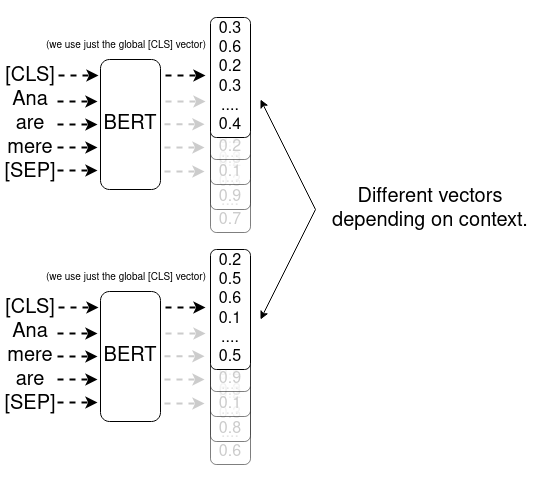

In [46]:
display.Image("https://i.imgur.com/RMxDXxf.png")

# Main takeaways:
1. Static word embeddings are still a very strong and fast baseline.
2. Transformers produce word embeddings dependent on the context but are harder and more expensive to train.
3. BERT provides a sequence-level embedding from the [CLS] token.
4. Contextual word embeddings are able to distinguish between tricky examples ('produsul nu e bun e chiar destul de rau' vs. 'produsul nu e rau e chiar destul de bun'), where static word embeddings fail.